In [1]:
import sys
print(sys.version)
print(sys.path)

3.7.9 (default, Jan  8 2021, 17:41:21) 
[GCC 7.5.0]
['/home/tokudo/Develop/grips/unicorn/notebooks', '/home/tokudo/.pyenv/versions/3.7.9/lib/python37.zip', '/home/tokudo/.pyenv/versions/3.7.9/lib/python3.7', '/home/tokudo/.pyenv/versions/3.7.9/lib/python3.7/lib-dynload', '', '/home/tokudo/Develop/grips/unicorn/venv/lib/python3.7/site-packages', '/home/tokudo/Develop/grips/grina', '/home/tokudo/Develop/grips/unicorn/venv/lib/python3.7/site-packages/IPython/extensions', '/home/tokudo/.ipython']


In [2]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import grina
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
fpath = os.path.join("..", "data", "unicorn_company_invester.csv")
df = pd.read_csv(fpath, converters={"Select Investors": lambda x: x.split(",")})

In [4]:
def trans2float(x):
    y = x[1:]
    return float(y)

df["Valuation($B) flaot"] = df["Valuation($B)"].apply(trans2float)

In [5]:
df["Valuation($B) flaot"].describe()

count    501.000000
mean       3.185749
std        7.676841
min        1.000000
25%        1.000000
50%        1.500000
75%        3.000000
max      140.000000
Name: Valuation($B) flaot, dtype: float64

In [6]:
df["DateTime Joined"] = df["Date Joined"].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

In [7]:
df.head()

,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
0,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.0,2018-04-18
1,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.0,2018-03-07
2,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.5,2015-07-03
3,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.0,2018-12-19
4,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.0,2015-10-12


In [8]:
def clean(element):
    return element.strip()

In [9]:
r_comps, r_invests = [], []
for company, investors in df[["Company", "Select Investors"]].values.tolist():
    n_rows = len(investors)
    comps = np.full(n_rows, company)
    r_comps += comps.tolist()
    r_invests += investors
r_comps = list(map(clean, r_comps))
r_invests = list(map(clean, r_invests))

In [10]:
# Unicornで投資を行っている企業が存在するため、2部グラフにするためにInvester&Unicornの場合はInvester名に"_"を追加
for i, invest in enumerate(r_invests):
    if invest in r_comps:
        print(invest)
        r_invests[i] = invest + "_"

Didi Chuxing
Bitmain Technologies
Grab
Tokopedia


In [11]:
rdf = pd.DataFrame()
rdf["Company"] = np.array(r_comps)
rdf["Investors"] = np.array(r_invests)
rdf

,Company,Investors
0,100credit,Sequoia Capital China
1,100credit,China Reform Fund
2,100credit,Hillhouse Capital Management
3,17zuoye,DST Global
4,17zuoye,Temasek Holdings
...,...,...
1380,Zwift,True
1381,Zwift,Causeway Media Partners
1382,Zymergen,Data Collective
1383,Zymergen,True Ventures


In [12]:
B = nx.Graph()

In [13]:
B.add_nodes_from(rdf["Company"].unique().tolist(), bipartite=0)
B.add_nodes_from(rdf["Investors"].unique().tolist(), bipartite=1)

In [14]:
edges = [(comp, inve) for comp, inve in zip(rdf["Company"], rdf["Investors"])]
B.add_edges_from(edges)

In [15]:
from networkx.algorithms import bipartite
company_graph = bipartite.projected_graph(B, set(rdf["Company"].tolist()))
investor_graph = bipartite.projected_graph(B, set(rdf["Investors"].tolist()))

In [16]:
company_graph_pd = nx.to_pandas_edgelist(company_graph)

In [17]:
investor_graph_pd = nx.to_pandas_edgelist(investor_graph)

In [18]:
bipartite_graph_pd = nx.to_pandas_edgelist(B)

In [19]:
print("ファイルを出力しますか？[y/n]")
b = input()
if b == "y":
    bipartite_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "bipartite_graph.csv"))
    company_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "company_graph.csv"))
    investor_graph_pd.to_csv(os.path.join("..", "out", "edgelist", "investor_graph.csv"))
    print("Done!!")

ファイルを出力しますか？[y/n]
y
Done!!


# 2部グラフ分析

In [20]:
vc_invest_df = pd.merge(bipartite_graph_pd, df, left_on="source", right_on="Company", how="left")
vc_invest_df.drop(["Select Investors", "source"], axis=1, inplace=True)
vc_invest_df.head()

,target,Company,Valuation($B),Date Joined,Country,Industry,Valuation($B) flaot,DateTime Joined
0,Sequoia Capital China,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
1,China Reform Fund,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
2,Hillhouse Capital Management,100credit,$1,4/18/2018,China,Fintech,1.0,2018-04-18
3,DST Global,17zuoye,$1,3/7/2018,China,Edtech,1.0,2018-03-07
4,Temasek Holdings,17zuoye,$1,3/7/2018,China,Edtech,1.0,2018-03-07


In [21]:
analysis_invest_df = vc_invest_df.groupby("target", as_index=False).agg(
    {
        "Valuation($B) flaot": ["sum", "count", "mean"],
        "Country": [lambda x: len(x.unique()), set],
        "Industry": [lambda x: len(x.unique()), set],
        "Company": [lambda x: len(x.unique()), set],
        "DateTime Joined": "min",
    }
)
analysis_invest_df

target Valuation($B) flaot                Country  \
                                    sum count  mean <lambda_0>   
0       01 Advisors                2.00     1  2.00          1   
1      500 Startups                4.50     2  2.25          2   
2            58.com                3.00     2  1.50          1   
3        5Y Capital                1.22     1  1.22          1   
4           83North               11.55     5  2.31          3   
..              ...                 ...   ...   ...        ...   
690         iFLYTEK                1.00     1  1.00          1   
691  iNovia Capital                1.04     1  1.04          1   
692   iTech Capital                1.00     1  1.00          1   
693  index Ventures                5.50     1  5.50          1   
694          next47                1.60     1  1.60          1   

                                        Industry  \
                                  set <lambda_0>   
0                     {United States}          1   
1            {Philippines, Indonesia}          2   
2                             {China}          1   
3                             {China}          1   
4    {United States, Germany, France}          4   
..                                ...        ...   
690                           {China}          1   
691                   {United States}          1   
692                     {Netherlands}          1   
693                  {United Kingdom}          1   
694                   {United States}          1   

                                                          Company  \
                                                   set <lambda_0>   
0                                            {Fintech}          1   
1             {E-commerce & direct-to-consumer, Other}          2   
2                    {E-commerce & direct-to-consumer}          2   
3                        {Mobile & telecommunications}          1   
4    {E-commerce & direct-to-consumer, Auto & trans...          5   
..                                                 ...        ...   
690                                         {Hardware}          1   
691                  {E-commerce & direct-to-consumer}          1   
692                                         {Hardware}          1   
693                                          {Fintech}          1   
694                                    {Cybersecurity}          1   

                                                       DateTime Joined  
                                                   set             min  
0                                            {Tipalti}      2020-10-06  
1                   {Revolution Precrafted, Bukalapak}      2017-10-23  
2                            {Zhuan Zhuan, Tubatu.com}      2015-03-09  
3                                        {GalaxySpace}      2020-11-17  
4    {Marqeta, Celonis, Via Transportation, Mirakl,...      2017-12-05  
..                                                 ...             ...  
690                              {TERMINUS Technology}      2018-10-25  
691                                        {AppDirect}      2015-10-07  
692                                          {BitFury}      2018-11-06  
693                                          {Revolut}      2018-04-26  
694                                          {Verkada}      2020-01-29  

[695 rows x 11 columns]

In [22]:
columns = ["Investor", "Total valuation($B)", "Valuation count", "Mean valuation($B)", "#countries", "Country set", "#industries", "Industry set", "#unicorns", "Unicorn set", "Oldest datetime joined"]
analysis_invest_df.columns = analysis_invest_df.columns.to_flat_index()
analysis_invest_df.columns = columns
analysis_invest_df.head()

,Investor,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,01 Advisors,2.00,1,2.00,1,{United States},1,{Fintech},1,{Tipalti},2020-10-06
1,500 Startups,4.50,2,2.25,2,"{Philippines, Indonesia}",2,"{E-commerce & direct-to-consumer, Other}",2,"{Revolution Precrafted, Bukalapak}",2017-10-23
2,58.com,3.00,2,1.50,1,{China},1,{E-commerce & direct-to-consumer},2,"{Zhuan Zhuan, Tubatu.com}",2015-03-09
3,5Y Capital,1.22,1,1.22,1,{China},1,{Mobile & telecommunications},1,{GalaxySpace},2020-11-17
4,83North,11.55,5,2.31,3,"{United States, Germany, France}",4,"{E-commerce & direct-to-consumer, Auto & trans...",5,"{Marqeta, Celonis, Via Transportation, Mirakl,...",2017-12-05


In [23]:
analysis_invest_df.to_csv(os.path.join("..", "out", "features", "investment_info.csv"))

# 中心性
## 投資家のグラフ

In [24]:
def get_centrality(G):
    degrees = nx.degree_centrality(G)
    betweens = nx.betweenness_centrality(G)
    eigens = nx.eigenvector_centrality(G, max_iter=1000)
    closeness = nx.closeness_centrality(G)
    page_ranks = nx.pagerank(G, max_iter=1000)
    centra_dict = {
        "Degree Centrality": degrees,
        "Betweenness Centrality": betweens,
        "Eigen Centrality": eigens,
        "Closeness Centrality": closeness,
        "Page Rank": page_ranks,
    }
    if type(G) == nx.DiGraph:
        in_degrees = nx.in_degree_centrality(G)
        out_degrees = nx.out_degree_centrality(G)
        elongations = grina.get_elongation(G)
        expansions = grina.get_degree_expansion(G)
        teacher_discs = grina.node_teacher_disciple_degree(G)
        colleagues = grina.node_colleague_degree(G)
        unidir_density = grina.node_unidirect_density(G)
        bidir_density = grina.node_bidirect_density(G)
        centra_dict["In-degree Centrality"] = in_degrees
        centra_dict["Out-degree Centrality"] = out_degrees
        centra_dict["Elongation"] = elongations
        centra_dict["Expansion"] = expansions
        centra_dict["Teacher Disciple Degree"] = teacher_discs
        centra_dict["Colleague Degree"] = colleagues
        centra_dict["Unidirect Density"] = unidir_density
        centra_dict["Bidirect Density"] = bidir_density
    return pd.DataFrame.from_dict(centra_dict)

In [25]:
investor_centrality_df = get_centrality(investor_graph).reset_index().rename({"index": "Investor"}, axis=1)
investor_centrality_df = pd.merge(investor_centrality_df, analysis_invest_df, on="Investor")
investor_centrality_df

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,North Bridge Growth Equity,0.002882,0.000000,4.401493e-03,0.174405,0.000882,1.00,1,1.000,1,{Portugal},1,{Internet software & services},1,{OutSystems},2018-06-05
1,Comcast Ventures,0.011527,0.005558,6.902556e-02,0.221102,0.002286,7.74,4,1.935,1,{United States},3,"{E-commerce & direct-to-consumer, Fintech, Int...",4,"{Vox Media, Hippo, Houzz, Away}",2014-09-30
2,ENIAC Ventures,0.002882,0.000000,2.586112e-02,0.202352,0.000706,18.00,1,18.000,1,{United States},1,{Travel},1,{Airbnb},2011-07-26
3,German Media Pool,0.001441,0.000000,1.583809e-20,0.001441,0.001475,1.00,1,1.000,1,{Germany},1,{E-commerce & direct-to-consumer},1,{About You},2018-07-19
4,First Round Capital,0.011527,0.003156,5.138329e-02,0.215273,0.002411,11.80,4,2.950,1,{United States},4,"{E-commerce & direct-to-consumer, Supply chain...",4,"{Roblox, Verkada, Warby Parker, Flexport}",2015-04-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,GAM Holding,0.000000,0.000000,1.888047e-27,0.000000,0.000221,1.60,1,1.600,1,{United States},1,{Artificial intelligence},1,{Afiniti},2017-04-14
691,500 Startups,0.004323,0.000008,7.493675e-16,0.004323,0.002168,4.50,2,2.250,2,"{Philippines, Indonesia}",2,"{E-commerce & direct-to-consumer, Other}",2,"{Revolution Precrafted, Bukalapak}",2017-10-23
692,Alibaba Entrepreneurs Fund,0.002882,0.000000,1.746503e-02,0.196404,0.000825,1.00,1,1.000,1,{Hong Kong},1,{Fintech},1,{WeLab},2017-11-08
693,CITIC Securities International,0.002882,0.000000,1.777468e-16,0.002882,0.001475,5.08,1,5.080,1,{China},1,{Health},1,{United Imaging Healthcare},2017-09-15


## 企業のネットワーク


In [26]:
company_centrality_df = get_centrality(company_graph)
company_centrality_df = company_centrality_df.reset_index().rename({"index": "Company"},axis=1) 
company_centrality_df = pd.merge(company_centrality_df, df, on="Company")
company_centrality_df.head()

,Company,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
0,Skydance Media,0.042,0.000000,0.081027,0.291831,0.002289,$2.30,2/11/2020,United States,Other,"[RedBird Capital Partners, CJ ENM, Tencent H...",2.3,2020-02-11
1,Gymshark,0.028,0.000000,0.010421,0.294313,0.001735,$1.30,8/14/2020,United Kingdom,E-commerce & direct-to-consumer,[General Atlantic],1.3,2020-08-14
2,Branch,0.034,0.000000,0.010182,0.305753,0.002174,$1,9/10/2018,United States,Mobile & telecommunications,"[New Enterprise Associates, Pear, Cowboy Ven...",1.0,2018-09-10
3,OVH,0.016,0.000000,0.005201,0.261414,0.001384,$1.10,8/15/2016,France,Other,"[KKR, TowerBrook Capital Partners]",1.1,2016-08-15
4,Playco,0.048,0.000602,0.024304,0.307382,0.002643,$1,9/21/2020,Japan,Other,"[Sozo Ventures, Caffeinated Capital, Sequoia...",1.0,2020-09-21


## 企業メモ
* Pony.aiは自動運転自動車の会社
* Ziroomは賃貸掲載サイトの運営会社（スーモやホームズみたいなサイトの中国版？）
* Rappiはコロンビアの会社で、買い物代行。Uber eatに近いサービスだと思う。

# コンポーネント

In [27]:
def describe_components(G):
    n_comps = nx.number_connected_components(G)
    print("コンポーネント数: {}".format(n_comps))
    print("ノード数に対するコンポーネント数の割合: {0:.2%}".format(n_comps / len(G)))
    S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    comp_sizes = [len(s) for s in S]
    print("投資家コンポーネント上位10件のサイズ")
    print(np.sort(comp_sizes)[::-1][:10])
    comp_sizes = np.sort(comp_sizes)[::-1]
    plt.plot(comp_sizes)
    print("ネットワーク密度: {0:.2%}".format(nx.density(S[0])))

コンポーネント数: 82
ノード数に対するコンポーネント数の割合: 11.80%
投資家コンポーネント上位10件のサイズ
[506   7   4   3   3   3   3   3   3   3]
ネットワーク密度: 0.85%


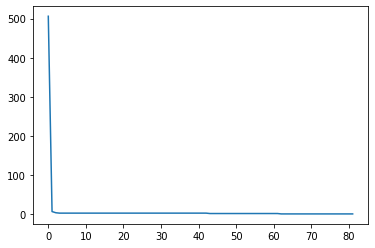

In [28]:
describe_components(investor_graph)

コンポーネント数: 82
ノード数に対するコンポーネント数の割合: 16.37%
投資家コンポーネント上位10件のサイズ
[417   3   2   1   1   1   1   1   1   1]
ネットワーク密度: 4.16%


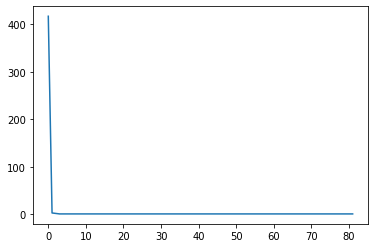

In [29]:
describe_components(company_graph)

## 企業 - 国・産業ネットワーク

In [30]:
country_industry_df = pd.merge(company_graph_pd, df[["Company", "Country", "Industry"]], left_on="source", right_on="Company", how="left")
country_industry_df = pd.merge(country_industry_df, df[["Company", "Country", "Industry"]], left_on="target", right_on="Company", how="left", suffixes=["_source", "_target"])
country_industry_df = country_industry_df.drop(["Company_source", "Company_target"], axis=1)
country_industry_df.head()

,source,target,Country_source,Industry_source,Country_target,Industry_target
0,Skydance Media,Miaoshou Doctor,United States,Other,China,E-commerce & direct-to-consumer
1,Skydance Media,Zhuan Zhuan,United States,Other,China,E-commerce & direct-to-consumer
2,Skydance Media,Luoji Siwei,United States,Other,China,Edtech
3,Skydance Media,Waterdrop,United States,Other,China,Fintech
4,Skydance Media,Epic Games,United States,Other,United States,Other


In [100]:
country_graph_df = country_industry_df.groupby(by=["Country_source", "Country_target"], as_index=False).agg({'source': 'count'})
country_graph_df.columns = ["source", "target", "weight"]
country_G = nx.from_pandas_edgelist(
    country_graph_df, create_using=nx.Graph, edge_attr=["weight"]
)
country_graph_df = nx.to_pandas_edgelist(country_G)
country_graph_df.to_csv(os.path.join("..", "out", "edgelist", "country_graph.csv"))
country_graph_matrix = nx.to_pandas_adjacency(country_G)
country_graph_matrix.to_csv(os.path.join("..", "out", "adjacency", "country_graph.csv"))

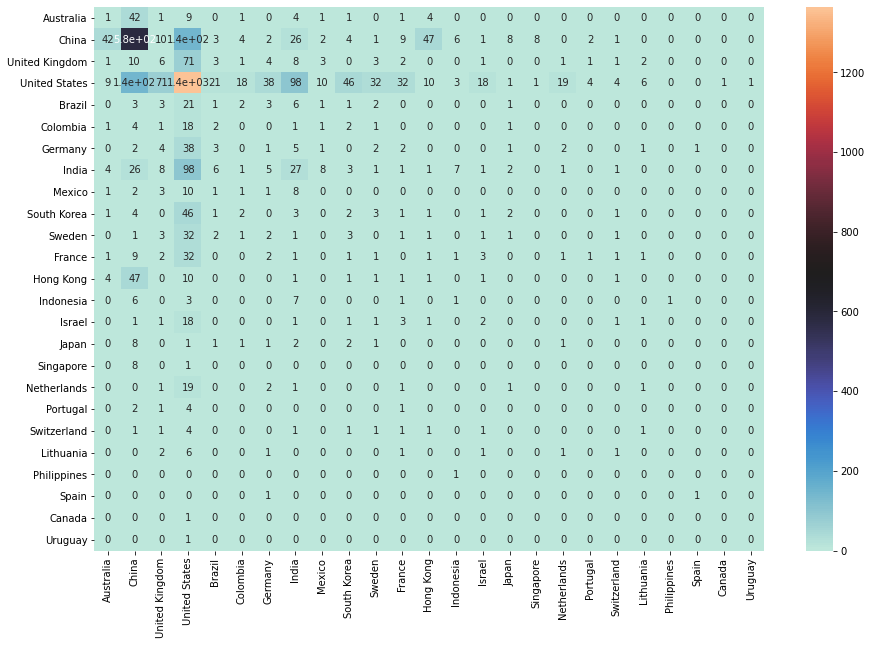

In [32]:
plt.figure(figsize=(15, 10))
sns.heatmap(country_graph_matrix, center=700, annot=True)
plt.savefig(os.path.join("..", "out", "adjacency", "country_graph.png"))

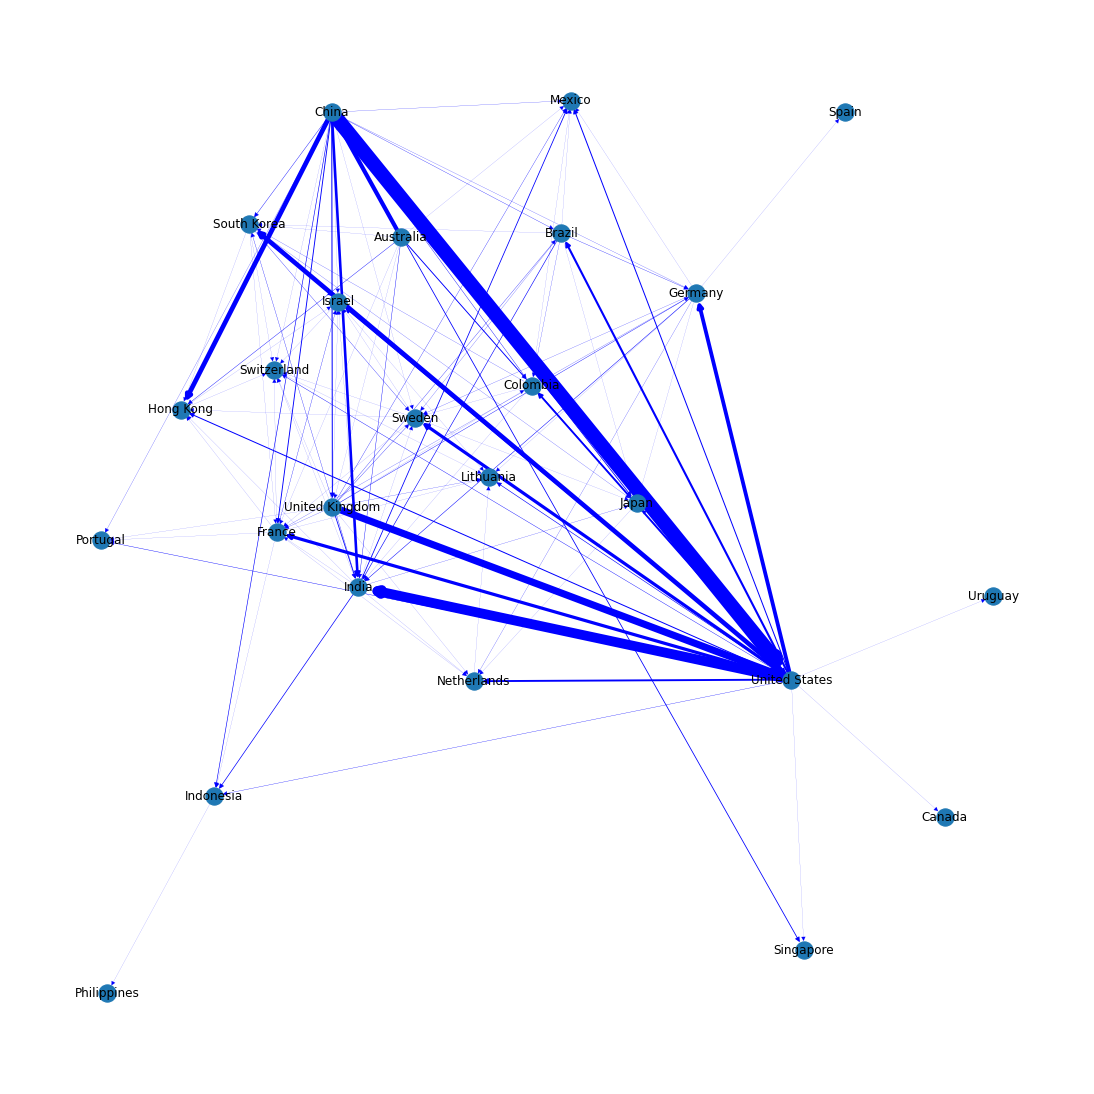

In [102]:
country_DG = nx.from_pandas_edgelist(
    country_graph_df, create_using=nx.DiGraph, edge_attr=["weight"]
)
edge_widths = [d['weight']/10 for _,_,d in country_DG.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    country_DG, width=edge_widths,
    pos=nx.kamada_kawai_layout(country_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join("..", "out", "edgelist", "country_dgraph.png"))
country_graph_df.to_csv(os.path.join("..", "out", "edgelist", "country_dgraph.csv"))

In [34]:
country_dgraph_matrix = nx.to_pandas_adjacency(country_DG)
country_dgraph_matrix.to_csv(os.path.join("..", "out", "adjacency", "country_dgraph.csv"))

In [101]:
industry_graph_df = country_industry_df.groupby(by=["Industry_source", "Industry_target"], as_index=False).agg({"source": 'count'})
industry_graph_df.columns = ["source", "target", "weight"]
industry_graph_df.to_csv()
industry_G = nx.from_pandas_edgelist(industry_graph_df, create_using=nx.Graph, edge_attr="weight")
industry_graph_df = nx.to_pandas_edgelist(industry_G)
industry_graph_df.to_csv(os.path.join("..", "out", "edgelist", "industry_graph.csv"))
industry_graph_matrix = nx.to_pandas_adjacency(industry_G)
industry_graph_matrix.to_csv(os.path.join("..", "out", "adjacency", "industry_graph.csv"))
industry_graph_df.head()

,source,target,weight
0,Artificial intelligence,Artificial intelligence,20
1,Artificial intelligence,Auto & transportation,12
2,Artificial intelligence,Consumer & retail,6
3,Artificial intelligence,Cybersecurity,10
4,Artificial intelligence,Data management & analytics,19


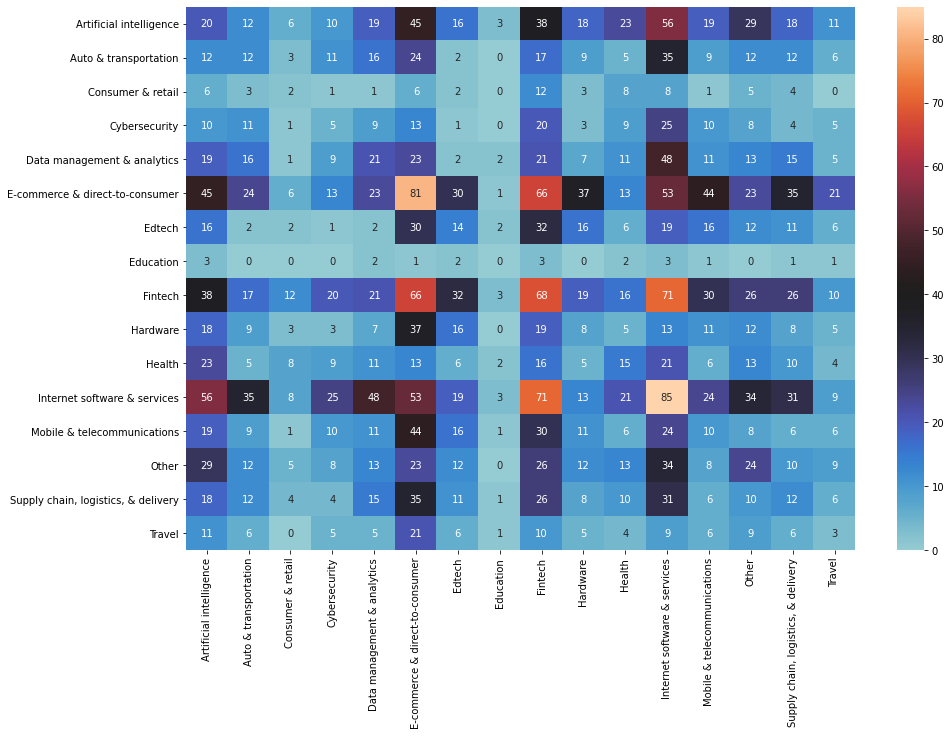

In [36]:
plt.figure(figsize=(15, 10))
sns.heatmap(industry_graph_matrix, center=40, annot=True)
plt.savefig(os.path.join("..", "out", "adjacency", "industry_graph.png"))

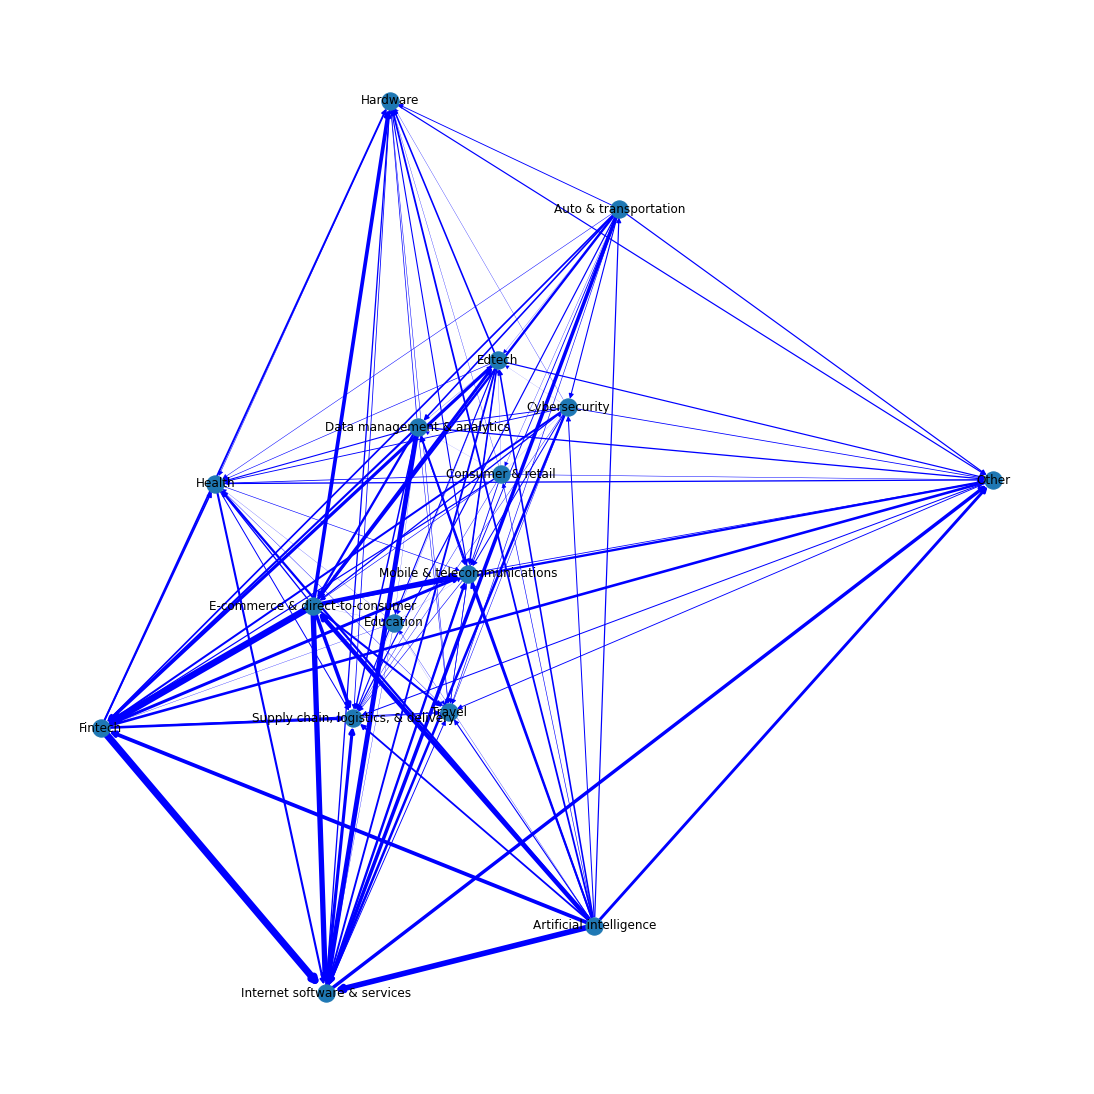

In [103]:
industry_DG = nx.from_pandas_edgelist(industry_graph_df, create_using=nx.DiGraph, edge_attr="weight")
edge_width = [v["weight"] * 0.1 for _, _, v in industry_G.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    industry_DG, width=edge_width, pos=nx.kamada_kawai_layout(industry_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join("..", "out", "edgelist", "industry_dgraph.png"))
industry_graph_df.to_csv(os.path.join("..", "out", "edgelist", "industry_dgraph.csv"))

In [38]:
industry_dgraph_matrix = nx.to_pandas_adjacency(industry_DG)
industry_dgraph_matrix.to_csv(os.path.join("..", "out", "adjacency", "industry_dgraph.csv"))

In [39]:
country_centrality_df = get_centrality(country_G)
industry_centrality_df = get_centrality(industry_G)

In [40]:
country_centrality_df.to_csv(os.path.join("..", "out", "features", "country_unicorn_centrality.csv"))

In [41]:
industry_centrality_df.to_csv(os.path.join("..", "out", "features", "industry_unicorn_centrality.csv"))

# 基本情報の出力
国ごとのバリュエーション、Industryごとのバリュエーションを出力

In [42]:
df.sort_values(by=["Date Joined"])

,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot,DateTime Joined
255,LinkSure Network,$1,1/1/2015,China,Mobile & telecommunications,[N/A],1.00,2015-01-01
242,Kuaishou,$18,1/1/2015,China,Mobile & telecommunications,"[Morningside Venture Capital, Sequoia Capital...",18.00,2015-01-01
244,L&P Cosmetic,$1.19,1/1/2016,South Korea,Consumer & retail,[CDIB Capital],1.19,2016-01-01
418,Traveloka,$3,1/1/2017,Indonesia,Travel,"[Global Founders Capital, East Ventures, Exp...",3.00,2017-01-01
24,AppLovin,$2,1/1/2017,United States,Mobile & telecommunications,"[Orient Hontai Capital, Webb Investment Network]",2.00,2017-01-01
...,...,...,...,...,...,...,...,...
275,Mia.com,$1,9/8/2015,China,E-commerce & direct-to-consumer,"[Sequoia Capital China, ZhenFund, K2 Ventures]",1.00,2015-09-08
302,OfferUp,$1.20,9/8/2016,United States,Mobile & telecommunications,"[Andreessen Horowitz, GGV Capital, T. Rowe P...",1.20,2016-09-08
280,Mollie,$1,9/8/2020,Netherlands,Fintech,[Technology Crossover Ventures],1.00,2020-09-08
460,WEMAKEPRICE,$2.34,9/9/2015,South Korea,E-commerce & direct-to-consumer,"[IMM Investment, NXC]",2.34,2015-09-09


In [43]:
stat_ind = ["mean", "sum", "min", "max", "count"]

In [44]:
country_group = df.groupby("Country").agg(stat_ind)
country_group.head()
cg_df = pd.DataFrame(country_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=country_group.index)
cg_df.sort_values(by=["sum"], ascending=False, inplace=True)
cg_df.head()

,mean,sum,min,max,count
Country,,,,,
United States,2.954321,717.90,1.0,46.00,243.0
China,4.379661,516.80,1.0,140.00,118.0
India,3.510400,87.76,1.0,16.00,25.0
United Kingdom,2.728750,65.49,1.0,11.08,24.0
South Korea,2.761818,30.38,1.0,9.00,11.0


In [45]:
industry_group = df.groupby("Industry").agg(stat_ind)
industry_group.head()
ig_df = pd.DataFrame(industry_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=industry_group.index)
ig_df.sort_values(by=["sum"], ascending=False, inplace=True)
ig_df.head()

,mean,sum,min,max,count
Industry,,,,,
Fintech,3.513099,249.43,1.0,36.0,71.0
Artificial intelligence,5.386444,242.39,1.0,140.0,45.0
E-commerce & direct-to-consumer,2.683594,171.75,1.0,15.0,64.0
Auto & transportation,4.915357,137.63,1.0,62.0,28.0
Internet software & services,2.047656,131.05,1.0,6.0,64.0


In [46]:
y = cg_df["mean"].values
x = cg_df.index.to_numpy()

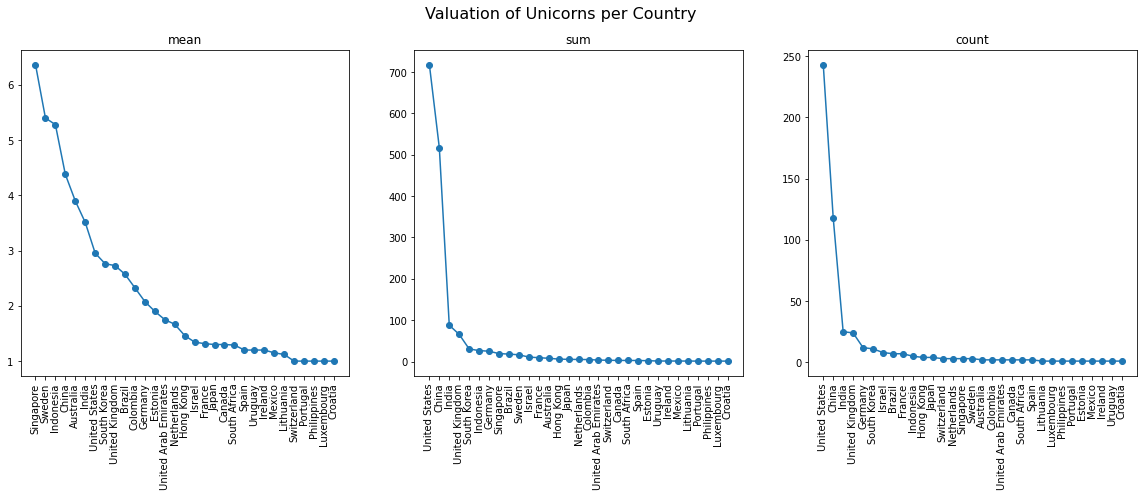

Complete output to ../out/features/value_per_country.png


In [47]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Country", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    cg_df.sort_values(by=[col], ascending=False, inplace=True)
    y = cg_df[col].values
    x = cg_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join("..", "out", "features", "value_per_country.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

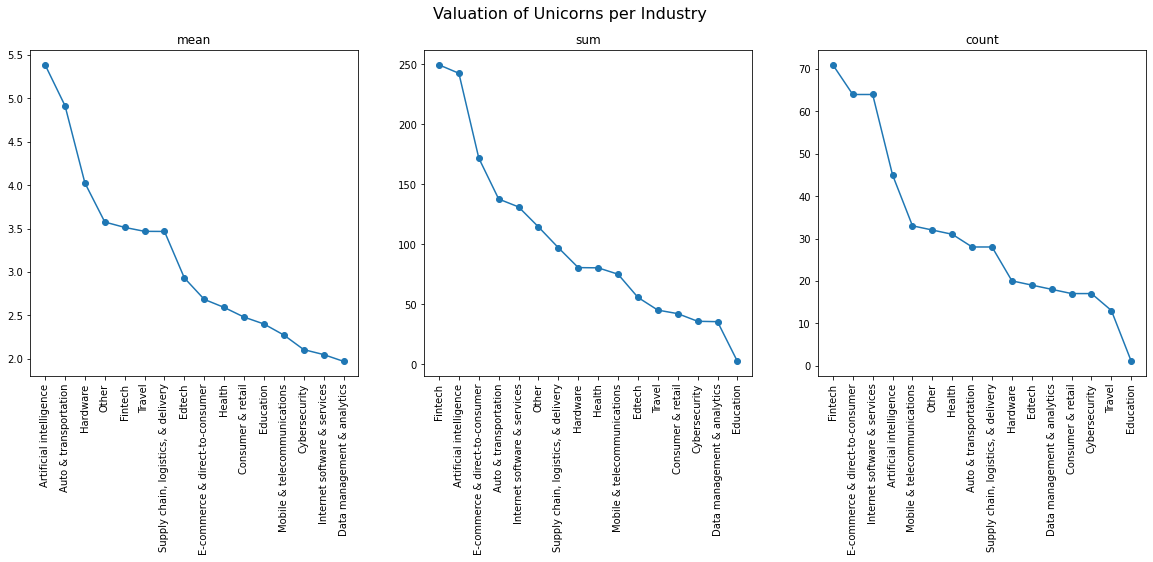

Complete output to ../out/features/value_per_industry.png


In [48]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Industry", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    ig_df.sort_values(by=[col], ascending=False, inplace=True)
    y = ig_df[col].values
    x = ig_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join("..", "out", "features", "value_per_industry.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

# 時系列可視化

In [49]:
print(len(df))
tdf = df.set_index("DateTime Joined")
tdf

501


,Company,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot
DateTime Joined,,,,,,,
2018-04-18,100credit,$1,4/18/2018,China,Fintech,"[Sequoia Capital China, China Reform Fund, H...",1.00
2018-03-07,17zuoye,$1,3/7/2018,China,Edtech,"[DST Global, Temasek Holdings]",1.00
2015-07-03,23andMe,$2.50,7/3/2015,United States,Health,"[Google Ventures, New Enterprise Associates, ...",2.50
2018-12-19,4Paradigm,$2,12/19/2018,China,Artificial intelligence,"[Sequoia Capital China, China Construction Ba...",2.00
2015-10-12,58 Daojia,$1,10/12/2015,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.00
...,...,...,...,...,...,...,...
2015-04-10,Zomato,$3.60,4/10/2015,India,Internet software & services,"[Sequoia Capital, VY Capital]",3.60
2018-11-01,Zume,$2.25,11/1/2018,United States,Consumer & retail,"[Softbank Group, AME Cloud Ventures, SignalF...",2.25
2018-07-18,Zuoyebang,$2,7/18/2018,China,Edtech,"[Sequoia Capital China, Xiang He Capital, GG...",2.00


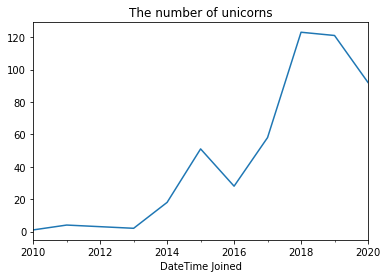

In [50]:
gdf = df.groupby(pd.Grouper(key="DateTime Joined", freq="Y")).agg("count")
gdf = gdf.reset_index().set_index("DateTime Joined")
gdf["Company"].plot(title="The number of unicorns")
plt.savefig(os.path.join("..", "out", "features", "n_unicorns_time_change.png"))

# ネットワークに時系列の要素を追加
カンパニーグラフは知識の流れを表していると解釈することができる。Date Joinedが遅い企業は、早い企業から知識を共有されていると考える。
そうした場合にどこの企業からどこの企業にVCを介して知識が伝播しているかを可視化する。

## ユニコーンネットワーク

In [51]:
company_graph_pd

,source,target
0,Skydance Media,Miaoshou Doctor
1,Skydance Media,Zhuan Zhuan
2,Skydance Media,Luoji Siwei
3,Skydance Media,Waterdrop
4,Skydance Media,Epic Games
...,...,...
3605,Figma,Sonder
3606,Podium,MessageBird
3607,Podium,UiPath
3608,MessageBird,UiPath


In [52]:
uc_date = df[["Company", "Date Joined", "Country", "Industry", "Valuation($B) flaot"]]
datetime_s = uc_date["Date Joined"].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))
uc_date["DateTime Joined"] = datetime_s
uc_date = uc_date.set_index("Company")
elem_dict = uc_date.to_dict("index")

/home/tokudo/Develop/grips/unicorn/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
uc_date.head()

,Date Joined,Country,Industry,Valuation($B) flaot,DateTime Joined
Company,,,,,
100credit,4/18/2018,China,Fintech,1.0,2018-04-18
17zuoye,3/7/2018,China,Edtech,1.0,2018-03-07
23andMe,7/3/2015,United States,Health,2.5,2015-07-03
4Paradigm,12/19/2018,China,Artificial intelligence,2.0,2018-12-19
58 Daojia,10/12/2015,China,Internet software & services,1.0,2015-10-12


In [54]:
sources = []
targets = []
for source, target in company_graph_pd.values:
        if elem_dict[source]["DateTime Joined"] > elem_dict[target]["DateTime Joined"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
comp_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
comp_dgraph_df

,source,target
0,Miaoshou Doctor,Skydance Media
1,Zhuan Zhuan,Skydance Media
2,Luoji Siwei,Skydance Media
3,Skydance Media,Waterdrop
4,Epic Games,Skydance Media
...,...,...
3605,Sonder,Figma
3606,Podium,MessageBird
3607,UiPath,Podium
3608,UiPath,MessageBird


In [55]:
# チェック用
print(elem_dict["Flexport"]["Date Joined"])
print(elem_dict["Knotel"]["Date Joined"])
print(elem_dict["Gong"]["Date Joined"])
print(elem_dict["VAST Data"]["Date Joined"])
print(elem_dict["Dave"]["Date Joined"])
print(elem_dict["Udemy"]["Date Joined"])

4/30/2018
8/21/2019
8/12/2020
4/16/2020
9/30/2019
2/19/2020


In [56]:
comp_dgraph = nx.from_pandas_edgelist(comp_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [57]:
# 国・産業ごとにノードに色付けのためのCMAP生成
cmap = plt.get_cmap("tab20b")
country_l = df["Country"].unique()
industry_l = df["Industry"].unique()
country_cmap = []
industry_cmap = []
val_size = []
max_val = df["Valuation($B) flaot"].max()
min_val = df["Valuation($B) flaot"].min()
diff = max_val - min_val
for n in comp_dgraph.nodes():
    industry = elem_dict[n]["Industry"]
    ind_idx = np.where(industry_l == industry)
    country = elem_dict[n]["Country"]
    cou_idx = np.where(country_l == country)
    industry_cmap.append(cmap(ind_idx))
    country_cmap.append(cmap(cou_idx))
    val_size.append(
        100 + (elem_dict[n]["Valuation($B) flaot"] - min_val)/diff*900
    )

In [58]:
country_cmap = list(map(lambda x: tuple(x[0][0]), country_cmap))
industry_cmap = list(map(lambda x: tuple(x[0][0]), industry_cmap))

In [59]:
val_size[:10]

[100.12949640287769,
 108.41726618705036,
 100.0,
 101.16546762589928,
 112.17266187050359,
 205.53956834532374,
 102.58992805755396,
 100.32374100719424,
 100.0,
 193.88489208633092]

In [60]:
# plt.figure(figsize=(100, 100))
# nx.draw_circular(comp_dgraph, font_size=8, node_size=val_size, node_color=country_cmap)
# plt.savefig(os.path.join("..", "out", "sen2jun_dgraph"))

In [61]:
comp_dgraph_centrality_df = get_centrality(comp_dgraph)
comp_dgraph_centrality_df = comp_dgraph_centrality_df.reset_index().rename({"index": "Company"}, axis=1)
comp_dgraph_centrality_df.head()
comp_dgraph_centrality_df = pd.merge(comp_dgraph_centrality_df, df, on="Company", how="left")

In [62]:
comp_dgraph_centrality_df.to_csv(os.path.join("..", "out", "features", "directed_unicorn_centrality.csv"))

## VCネットワーク

In [63]:
investor_graph_pd

,source,target
0,North Bridge Growth Equity,KKR
1,North Bridge Growth Equity,ES Ventures
2,Comcast Ventures,Accel Partners
3,Comcast Ventures,Horizons Ventures
4,Comcast Ventures,New Enterprise Associates
...,...,...
1235,ICONIQ Capital,Index Ventures
1236,Tencent,Tiger Global management
1237,Samsung Ventures,Delphi Automotive
1238,Index Ventures,Benchmark


In [64]:
datetime_df = analysis_invest_df[["Investor", "Oldest datetime joined"]]
datetime_df.columns = ["investor", "datetime"]
elem_dict = datetime_df.set_index("investor").to_dict("index")

In [65]:
sources = []
targets = []
for source, target in investor_graph_pd.values:
        if elem_dict[source]["datetime"] > elem_dict[target]["datetime"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
investor_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
investor_dgraph_df

,source,target
0,KKR,North Bridge Growth Equity
1,North Bridge Growth Equity,ES Ventures
2,Accel Partners,Comcast Ventures
3,Comcast Ventures,Horizons Ventures
4,New Enterprise Associates,Comcast Ventures
...,...,...
1235,Index Ventures,ICONIQ Capital
1236,Tencent,Tiger Global management
1237,Samsung Ventures,Delphi Automotive
1238,Index Ventures,Benchmark


In [66]:
investor_dgraph = nx.from_pandas_edgelist(investor_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [67]:
investor_dgraph_centrality_df = get_centrality(investor_dgraph)
investor_dgraph_centrality_df = investor_dgraph_centrality_df.reset_index().rename({"index": "Investor"}, axis=1)
investor_dgraph_centrality_df = pd.merge(investor_dgraph_centrality_df, analysis_invest_df, on="Investor", how="left")
investor_dgraph_centrality_df.to_csv(os.path.join("..", "out", "features", "directed_investor_centrality.csv"))
investor_dgraph_centrality_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,...,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,KKR,0.019288,0.000773,3.915941e-14,0.024459,0.001797,0.005935,0.013353,6,59,...,26.25,9,2.916667,5,"{China, France, Portugal, United States, Unite...",6,"{Supply chain, logistics, & delivery, Fintech,...",9,"{58 Daojia, OutSystems, OVH, Yiguo, Ivalua, Da...",2015-10-12
1,North Bridge Growth Equity,0.002967,0.000000,1.028016e-12,0.018782,0.001023,0.001484,0.001484,1,1,...,1.00,1,1.000000,1,{Portugal},1,{Internet software & services},1,{OutSystems},2018-06-05
2,ES Ventures,0.002967,0.000000,2.645859e-11,0.019466,0.001894,0.002967,0.000000,0,0,...,1.00,1,1.000000,1,{Portugal},1,{Internet software & services},1,{OutSystems},2018-06-05
3,Accel Partners,0.013353,0.000326,1.997695e-28,0.015579,0.001483,0.008902,0.004451,9,123,...,30.45,7,4.350000,5,"{China, India, France, United States, United K...",5,"{Supply chain, logistics, & delivery, Internet...",7,"{Deliveroo, Ola Cabs, Vox Media, Squarespace, ...",2014-08-13
4,Comcast Ventures,0.011869,0.000367,2.278563e-26,0.015261,0.001391,0.005935,0.005935,2,10,...,7.74,4,1.935000,1,{United States},3,"{E-commerce & direct-to-consumer, Fintech, Int...",4,"{Vox Media, Hippo, Houzz, Away}",2014-09-30


In [68]:
investor_dgraph_centrality_df.columns

Index(['Investor', 'Degree Centrality', 'Betweenness Centrality',
       'Eigen Centrality', 'Closeness Centrality', 'Page Rank',
       'In-degree Centrality', 'Out-degree Centrality', 'Elongation',
       'Expansion', 'Teacher Disciple Degree', 'Colleague Degree',
       'Unidirect Density', 'Bidirect Density', 'Total valuation($B)',
       'Valuation count', 'Mean valuation($B)', '#countries', 'Country set',
       '#industries', 'Industry set', '#unicorns', 'Unicorn set',
       'Oldest datetime joined'],
      dtype='object')

In [69]:
investor_data_df = investor_dgraph_centrality_df.drop(['Country set','Industry set', 'Unicorn set','Oldest datetime joined'], axis=1)
investor_data_df.corr()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
Degree Centrality,1.000000,0.826798,-0.019210,0.223363,0.153817,0.671733,0.956755,0.525904,0.560607,NaN,NaN,1.000000,NaN,0.710327,0.989324,0.055185,0.762981,0.954295,0.989324
Betweenness Centrality,0.826798,1.000000,-0.015099,0.218424,0.185863,0.620787,0.765363,0.441845,0.409847,NaN,NaN,0.826798,NaN,0.615513,0.822447,0.026398,0.561319,0.730454,0.822447
Eigen Centrality,-0.019210,-0.015099,1.000000,0.080091,0.161717,0.010758,-0.027671,-0.039606,-0.021216,NaN,NaN,-0.019210,NaN,-0.017839,-0.019928,-0.012095,-0.017562,-0.022025,-0.019928
Closeness Centrality,0.223363,0.218424,0.080091,1.000000,0.328220,0.577563,0.045825,-0.094136,-0.150082,NaN,NaN,0.223363,NaN,0.078390,0.196077,-0.003691,0.178940,0.196053,0.196077
Page Rank,0.153817,0.185863,0.161717,0.328220,1.000000,0.508510,-0.011943,-0.179259,-0.116703,NaN,NaN,0.153817,NaN,0.041246,0.134989,-0.022574,0.097728,0.117007,0.134989
In-degree Centrality,0.671733,0.620787,0.010758,0.577563,0.508510,1.000000,0.427191,0.181486,0.106342,NaN,NaN,0.671733,NaN,0.395555,0.644633,0.059360,0.511553,0.619395,0.644633
Out-degree Centrality,0.956755,0.765363,-0.027671,0.045825,-0.011943,0.427191,1.000000,0.570616,0.642480,NaN,NaN,0.956755,NaN,0.711649,0.954366,0.044046,0.730365,0.921522,0.954366
Elongation,0.525904,0.441845,-0.039606,-0.094136,-0.179259,0.181486,0.570616,1.000000,0.779749,NaN,NaN,0.525904,NaN,0.376940,0.523122,0.064111,0.408153,0.558508,0.523122
Expansion,0.560607,0.409847,-0.021216,-0.150082,-0.116703,0.106342,0.642480,0.779749,1.000000,NaN,NaN,0.560607,NaN,0.498661,0.560435,0.125432,0.412414,0.578427,0.560435
Teacher Disciple Degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


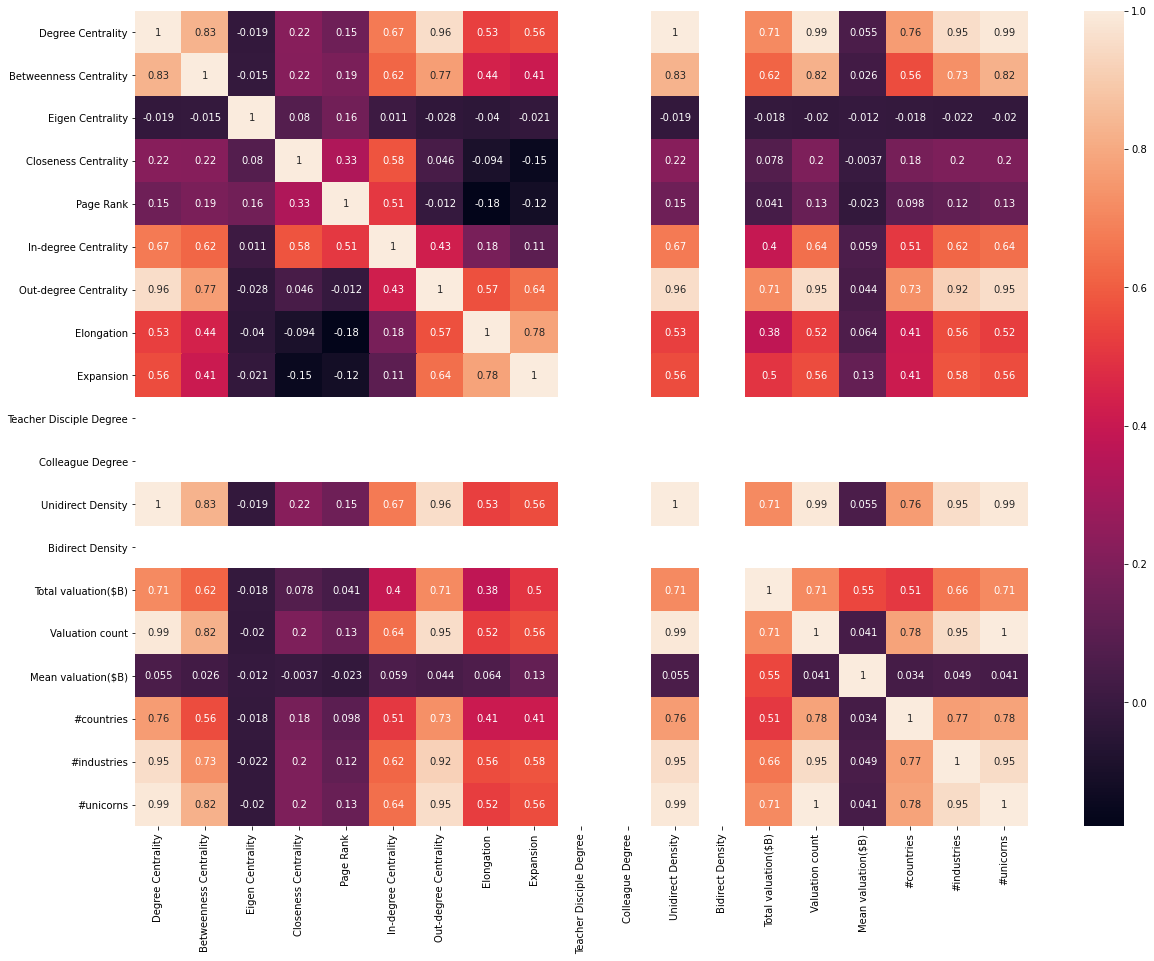

In [70]:
plt.figure(figsize=(20, 15))
sns.heatmap(investor_data_df.corr(), annot=True)
plt.savefig(os.path.join("..", "out", "features", "investor_correlation.png"))

In [71]:
value_df = df[["Company", "Valuation($B) flaot"]]
value_df.head()

,Company,Valuation($B) flaot
0,100credit,1.0
1,17zuoye,1.0
2,23andMe,2.5
3,4Paradigm,2.0
4,58 Daojia,1.0


In [72]:
unicorn_data_df = pd.merge(comp_dgraph_centrality_df, value_df, on="Company", how="left").set_index("Company")

In [73]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Miaoshou Doctor,0.116390,0.000782,2.299634e-14,0.198848,0.007969,0.106888,0.009501,1,4,1.0,...,0.058057,0.0,$1.02,6/27/2019,China,E-commerce & direct-to-consumer,"[Sequoia Capital China, Qiming Venture Partne...",1.02,2019-06-27,1.02
Skydance Media,0.049881,0.000000,2.698239e-13,0.162578,0.005114,0.045131,0.004751,1,2,1.0,...,0.024882,0.0,$2.30,2/11/2020,United States,Other,"[RedBird Capital Partners, CJ ENM, Tencent H...",2.30,2020-02-11,2.30
Zhuan Zhuan,0.052257,0.000061,6.276175e-45,0.014108,0.000892,0.007126,0.045131,6,217,1.0,...,0.026066,0.0,$1,4/18/2017,China,E-commerce & direct-to-consumer,"[58.com, Tencent Holdings]",1.00,2017-04-18,1.00
Luoji Siwei,0.116390,0.003242,1.136954e-41,0.029391,0.001199,0.026128,0.090261,5,211,1.0,...,0.058057,0.0,$1.18,7/20/2017,China,Edtech,"[Sequoia Capital China, Qiming Venture Partne...",1.18,2017-07-20,1.18
Waterdrop,0.092637,0.000000,1.911994e-05,0.245226,0.027574,0.092637,0.000000,0,0,1.0,...,0.046209,0.0,$2.88,8/20/2020,China,Fintech,"[Tencent Holdings, IDG Capital, Gaorong Capi...",2.88,2020-08-20,2.88


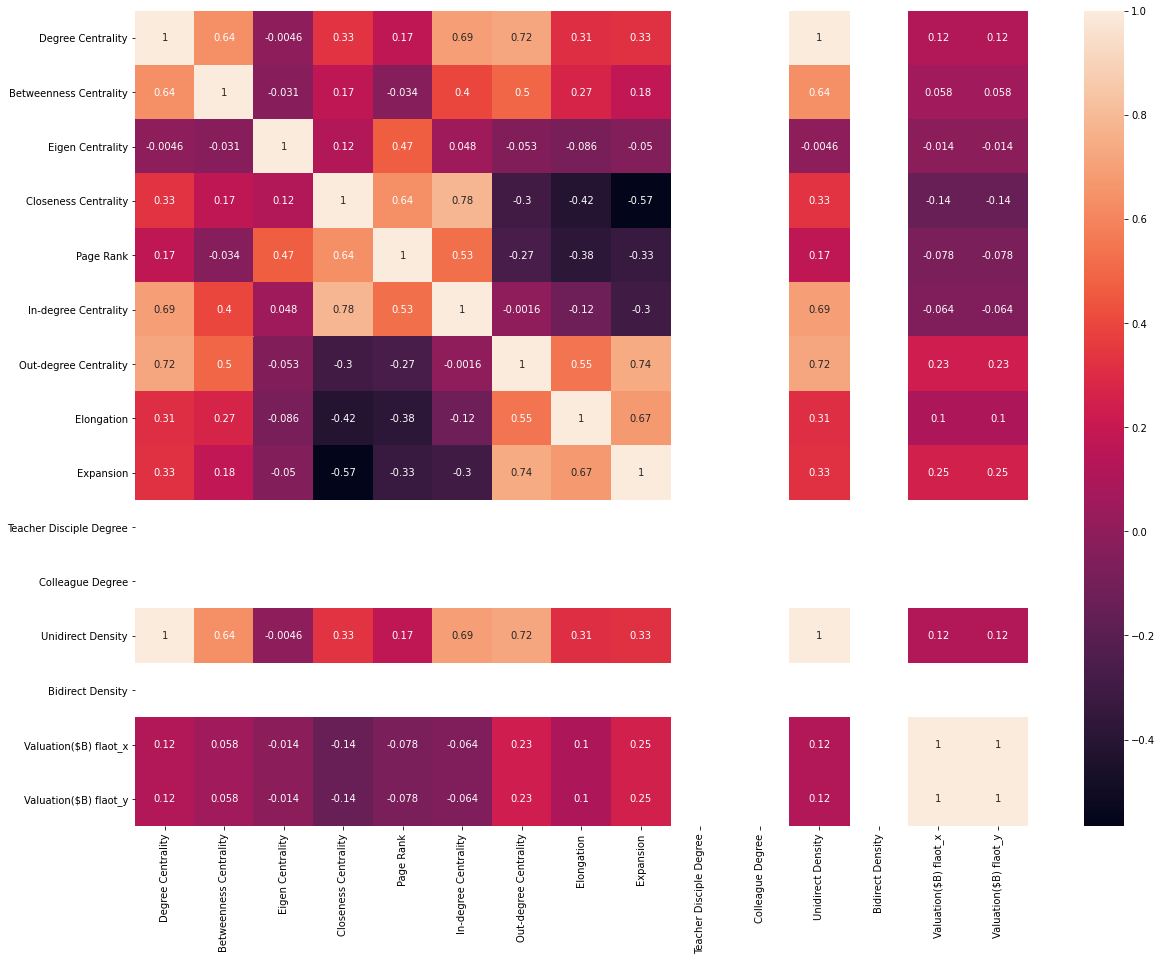

In [74]:
plt.figure(figsize=(20, 15))
sns.heatmap(unicorn_data_df.corr(), annot=True)
plt.savefig(os.path.join("..", "out", "features", "unicorn_correlation.png"))

valuationとユニコーン有向ネットワークの中心性との間に相関は見られない。

* 国ごと産業ごとの比較。
* 名寄せの問題。これは細かいので後回し
* 仮説を立てる。
  * VCのネットワークの意味は？
    * 何の関係を表してる？情報の流れ？
  * ユニコーンのネットワークの意味は？
    * 情報の流れ

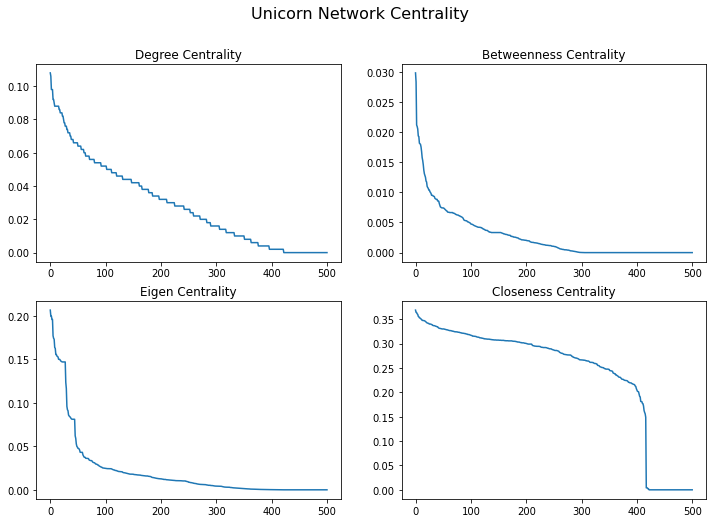

In [75]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Unicorn Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "unicorn_network_centrality.png"))

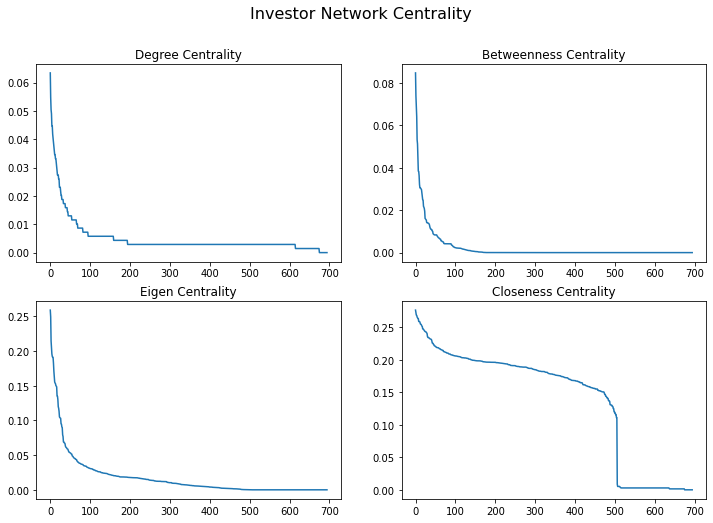

In [76]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Investor Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "investor_network_centrality.png"))

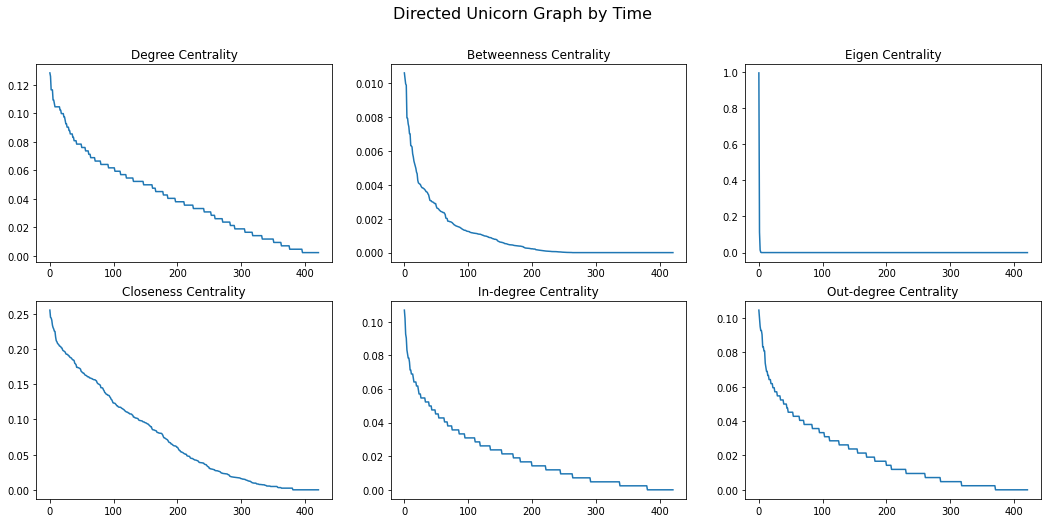

In [77]:
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Directed Unicorn Graph by Time", fontsize=16)
ax1 = fig.add_subplot(231)
col = "Degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(232)
col = "Betweenness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(233)
col = "Eigen Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(234)
col = "Closeness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
ax5 = fig.add_subplot(235)
col = "In-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax5.set_title(col)
ax5.plot(x, y)
ax6 = fig.add_subplot(236)
col = "Out-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax6.set_title(col)
ax6.plot(x, y)
plt.savefig(os.path.join("..", "out", "features", "directed_unicorn_centrality.png"))

# データの出力

In [78]:
investor_centrality_df.to_csv(os.path.join("..", "out", "features", "investor_centrality.csv"))
company_centrality_df.to_csv(os.path.join("..", "out", "features", "unicorn_centrality.csv"))

In [99]:
unicorn_data_df.corr().to_csv(os.path.join("..", "out", "features", "unicorn_correlation.csv"))
investor_data_df.corr().to_csv(os.path.join("..", "out", "features", "investor_correlation.csv"))

# 回帰分析

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

## ユニコーン回帰分析

In [81]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation($B),Date Joined,Country,Industry,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Miaoshou Doctor,0.116390,0.000782,2.299634e-14,0.198848,0.007969,0.106888,0.009501,1,4,1.0,...,0.058057,0.0,$1.02,6/27/2019,China,E-commerce & direct-to-consumer,"[Sequoia Capital China, Qiming Venture Partne...",1.02,2019-06-27,1.02
Skydance Media,0.049881,0.000000,2.698239e-13,0.162578,0.005114,0.045131,0.004751,1,2,1.0,...,0.024882,0.0,$2.30,2/11/2020,United States,Other,"[RedBird Capital Partners, CJ ENM, Tencent H...",2.30,2020-02-11,2.30
Zhuan Zhuan,0.052257,0.000061,6.276175e-45,0.014108,0.000892,0.007126,0.045131,6,217,1.0,...,0.026066,0.0,$1,4/18/2017,China,E-commerce & direct-to-consumer,"[58.com, Tencent Holdings]",1.00,2017-04-18,1.00
Luoji Siwei,0.116390,0.003242,1.136954e-41,0.029391,0.001199,0.026128,0.090261,5,211,1.0,...,0.058057,0.0,$1.18,7/20/2017,China,Edtech,"[Sequoia Capital China, Qiming Venture Partne...",1.18,2017-07-20,1.18
Waterdrop,0.092637,0.000000,1.911994e-05,0.245226,0.027574,0.092637,0.000000,0,0,1.0,...,0.046209,0.0,$2.88,8/20/2020,China,Fintech,"[Tencent Holdings, IDG Capital, Gaorong Capi...",2.88,2020-08-20,2.88


In [82]:
unicorn_data_df.columns

Index(['Degree Centrality', 'Betweenness Centrality', 'Eigen Centrality',
       'Closeness Centrality', 'Page Rank', 'In-degree Centrality',
       'Out-degree Centrality', 'Elongation', 'Expansion',
       'Teacher Disciple Degree', 'Colleague Degree', 'Unidirect Density',
       'Bidirect Density', 'Valuation($B)', 'Date Joined', 'Country',
       'Industry', 'Select Investors', 'Valuation($B) flaot_x',
       'DateTime Joined', 'Valuation($B) flaot_y'],
      dtype='object')

In [83]:
train_df = unicorn_data_df.drop([
    'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors',
    'DateTime Joined', 'Valuation($B) flaot_y', "Colleague Degree", "Bidirect Density",
    "Teacher Disciple Degree"
], axis=1)
# [
#     'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors', 'DateTime Joined', 'Valuation($B) flaot_y', 'Degree Centrality',
#     'Elongation', 'Expansion', 'Unidirect Density', 'Teacher Disciple Degree', 'Colleague Degree', 'Bidirect Density', 'In-degree Centrality',
#     'Page Rank'
# ] -> r2: 0.0615236981958418
d = ["Betweenness Centrality", "Elongation", "Page Rank", "Eigen Centrality",
     "Closeness Centrality", 'In-degree Centrality', "Degree Centrality", "Unidirect Density"]
train_df.drop(d, axis=1, inplace=True)
train_df.head()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x
Company,,,
Miaoshou Doctor,0.009501,4,1.02
Skydance Media,0.004751,2,2.30
Zhuan Zhuan,0.045131,217,1.00
Luoji Siwei,0.090261,211,1.18
Waterdrop,0.000000,0,2.88


<AxesSubplot:>

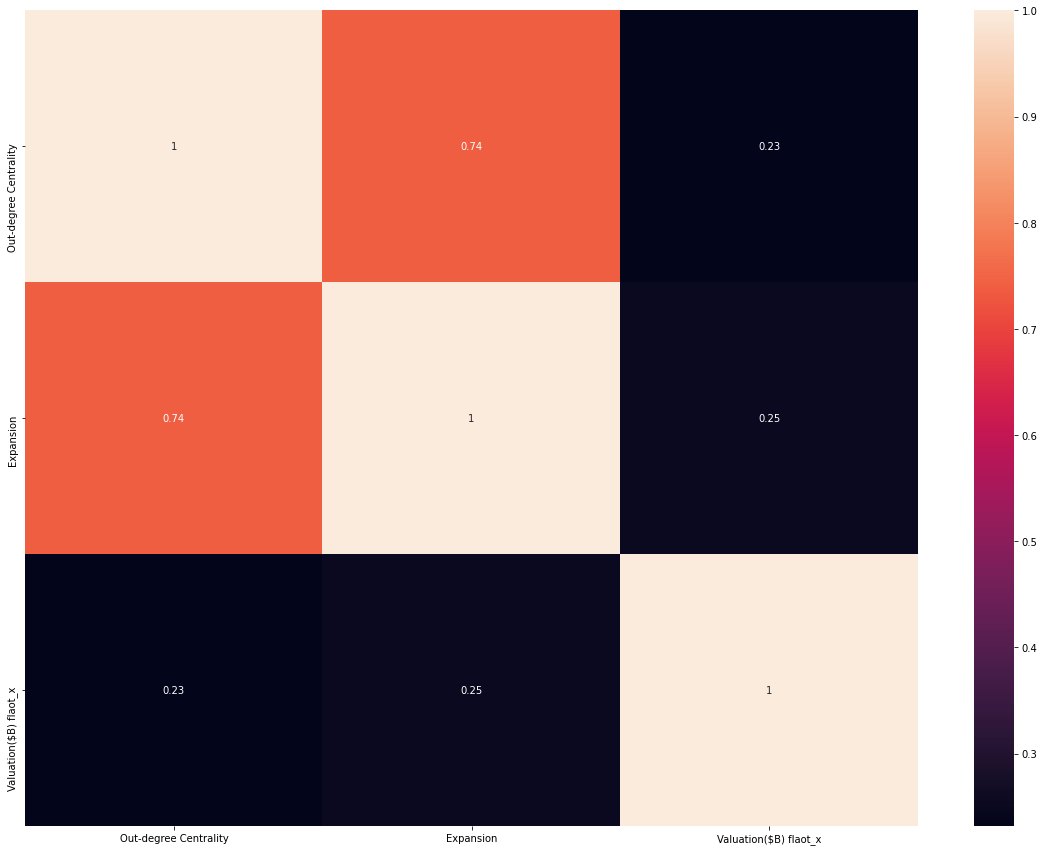

In [84]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df.corr(), annot=True)

In [85]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]

In [86]:
mod = sm.OLS(y, sm.add_constant(x))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     15.37
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           3.62e-07
Time:                        18:38:56   Log-Likelihood:                -583.85
No. Observations:                 422   AIC:                             1174.
Df Residuals:                     419   BIC:                             1186.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.489e-17      0.047   -1.8e-15      1.000      -0.093       0.093
x1             0.0990      0.070      1.411      0.159      -0.039       0.237
x2             0.1795      0.070      2.559      0.011       0.042       0.317
==============================================================================
Omnibus:                      792.858   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           600407.050
Skew:                          12.009   Prob(JB):                         0.00
Kurtosis:                     186.220   Cond. No.                         2.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
train_df.columns[:-1]

Index(['Out-degree Centrality', 'Expansion'], dtype='object')

In [88]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Valuation($B) flaot_x"][:-1].values)

array([0., 0.])

In [89]:
with open(os.path.join("..", "out", "features", "unicorn_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())

## VC回帰分析

In [90]:
investor_data_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
0,KKR,0.019288,0.000773,3.915941e-14,0.024459,0.001797,0.005935,0.013353,6,59,1.0,0.0,0.009630,0.0,26.25,9,2.916667,5,6,9
1,North Bridge Growth Equity,0.002967,0.000000,1.028016e-12,0.018782,0.001023,0.001484,0.001484,1,1,1.0,0.0,0.001481,0.0,1.00,1,1.000000,1,1,1
2,ES Ventures,0.002967,0.000000,2.645859e-11,0.019466,0.001894,0.002967,0.000000,0,0,1.0,0.0,0.001481,0.0,1.00,1,1.000000,1,1,1
3,Accel Partners,0.013353,0.000326,1.997695e-28,0.015579,0.001483,0.008902,0.004451,9,123,1.0,0.0,0.006667,0.0,30.45,7,4.350000,5,5,7
4,Comcast Ventures,0.011869,0.000367,2.278563e-26,0.015261,0.001391,0.005935,0.005935,2,10,1.0,0.0,0.005926,0.0,7.74,4,1.935000,1,3,4


In [91]:
investor_data_df.describe()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
count,675.000000,675.000000,6.750000e+02,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000,675.0,675.0,675.000000,675.0,675.000000,675.000000,675.000000,675.000000,675.000000,675.000000
mean,0.005451,0.000159,2.428321e-03,0.012743,0.001481,0.002726,0.002726,1.565926,28.500741,1.0,0.0,0.002722,0.0,6.851896,2.022222,2.959295,1.257778,1.644444,2.022222
std,0.007363,0.000625,3.844183e-02,0.011466,0.000610,0.002369,0.006032,2.407893,84.800646,0.0,0.0,0.003676,0.0,18.237397,2.981811,7.060772,0.823565,1.617168,2.981811
min,0.001484,0.000000,1.219791e-43,0.000000,0.000854,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000741,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.002967,0.000000,1.257098e-38,0.002324,0.000983,0.001484,0.000000,0.000000,0.000000,1.0,0.0,0.001481,0.0,1.085000,1.000000,1.037500,1.000000,1.000000,1.000000
50%,0.002967,0.000000,5.888752e-25,0.010422,0.001266,0.002967,0.001484,1.000000,1.000000,1.0,0.0,0.001481,0.0,2.000000,1.000000,1.600000,1.000000,1.000000,1.000000
75%,0.004451,0.000000,1.028061e-12,0.021746,0.001807,0.002967,0.002967,1.000000,2.000000,1.0,0.0,0.002222,0.0,4.450000,2.000000,2.666667,1.000000,2.000000,2.000000
max,0.065282,0.009117,7.242868e-01,0.050890,0.004259,0.017804,0.054896,12.000000,445.000000,1.0,0.0,0.032593,0.0,225.280000,28.000000,140.000000,9.000000,13.000000,28.000000


In [92]:
investor_data_df = investor_data_df.set_index("Investor")

In [93]:
train_df = investor_data_df.drop(["Valuation count", "Mean valuation($B)", "Bidirect Density", "Colleague Degree", "Teacher Disciple Degree"], axis=1)
target = train_df["Total valuation($B)"]
train_df.drop("Total valuation($B)", axis=1, inplace=True)
train_df["Total valuation($B)"] = target
d = [
    "Degree Centrality", 'Closeness Centrality', 'Page Rank', 'Unidirect Density', '#countries', '#industries', "Elongation",
    'Eigen Centrality', 'In-degree Centrality', 'Out-degree Centrality'
]
train_df = train_df.drop(d, axis=1)
train_df.describe()

,Betweenness Centrality,Expansion,#unicorns,Total valuation($B)
count,675.000000,675.000000,675.000000,675.000000
mean,0.000159,28.500741,2.022222,6.851896
std,0.000625,84.800646,2.981811,18.237397
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,1.085000
50%,0.000000,1.000000,1.000000,2.000000
75%,0.000000,2.000000,2.000000,4.450000
max,0.009117,445.000000,28.000000,225.280000


In [94]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
# y = sc.fit_transform(y)

In [95]:
mod = sm.OLS(y, sm.add_constant(x))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     247.5
Date:                Fri, 16 Apr 2021   Prob (F-statistic):          4.26e-108
Time:                        18:38:56   Log-Likelihood:                -706.36
No. Observations:                 675   AIC:                             1421.
Df Residuals:                     671   BIC:                             1439.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.633e-17      0.027   2.87e-15      1.000      -0.052       0.052
x1             0.1181      0.047      2.512      0.012       0.026       0.211
x2             0.1545      0.032      4.781      0.000       0.091       0.218
x3             0.5278      0.052     10.187      0.000       0.426       0.629
==============================================================================
Omnibus:                      952.880   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           196501.610
Skew:                           7.619   Prob(JB):                         0.00
Kurtosis:                      85.186   Cond. No.                         3.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
train_df.columns[:-1]

Index(['Betweenness Centrality', 'Expansion', '#unicorns'], dtype='object')

In [97]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Total valuation($B)"][:-1].values)

array([0., 0., 0.])

In [98]:
with open(os.path.join("..", "out", "features", "investor_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())